In [16]:
#Import the Libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pickle
import numpy as np

#Load the “Monatszahlen Verkehrsunfälle” Dataset
df = pd.read_csv('monatszahlen2501_verkehrsunfaelle_27_02_25.csv')

print(df.head())

       MONATSZAHL AUSPRAEGUNG  JAHR   MONAT  WERT  VORJAHRESWERT  \
0  Alkoholunfälle   insgesamt  2024  202401   NaN            NaN   
1  Alkoholunfälle   insgesamt  2024  202402   NaN            NaN   
2  Alkoholunfälle   insgesamt  2024  202403   NaN            NaN   
3  Alkoholunfälle   insgesamt  2024  202404   NaN            NaN   
4  Alkoholunfälle   insgesamt  2024  202405   NaN            NaN   

   VERAEND_VORMONAT_PROZENT  VERAEND_VORJAHRESMONAT_PROZENT  \
0                       NaN                             NaN   
1                       NaN                             NaN   
2                       NaN                             NaN   
3                       NaN                             NaN   
4                       NaN                             NaN   

   ZWOELF_MONATE_MITTELWERT  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  


In [17]:
# Only consider the first 5 columns of the dataset
df = df.iloc[:, :5].reset_index(drop=True)

# Remove rows where MONAT is not in YYYYMM format (e.g., "Summe")
df = df[df['MONAT'].astype(str).str.match(r'^\d{6}$')].copy()

train_df = df[df['JAHR'] <= 2020]

test_df = df[df['JAHR'] > 2020]

print("Number of the rows in the Training Dataset :", len(train_df))
print("Number of the rows in the Test Dataset :", len(test_df))

Number of the rows in the Training Dataset : 1764
Number of the rows in the Test Dataset : 336


In [20]:
# Checks whether the training dataset contains any null values
train_df.isnull().values.any()

False

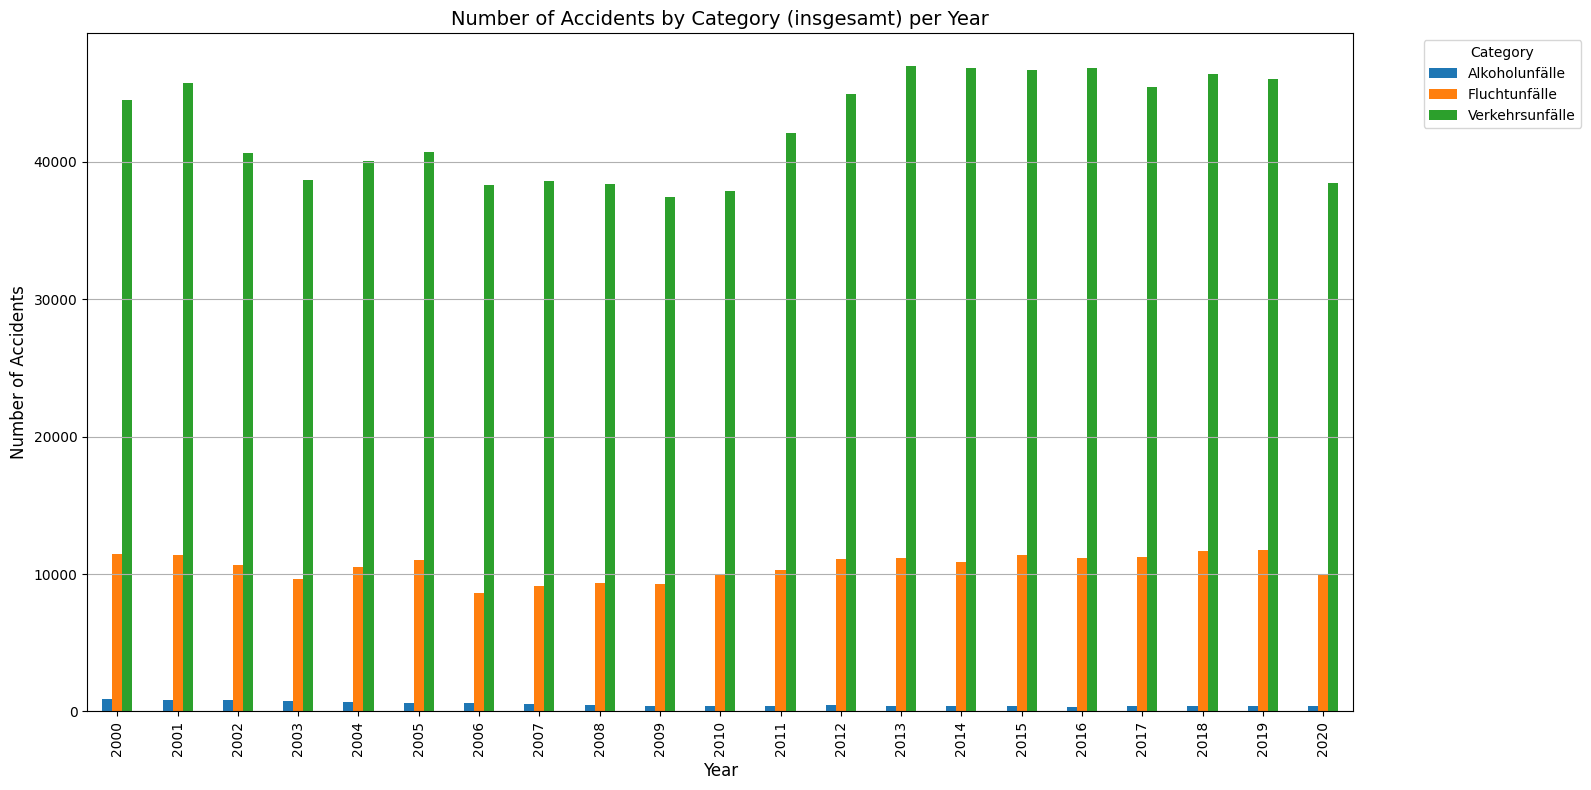

In [21]:
# Filter train_df for AUSPRAEGUNG == 'insgesamt' only
filtered_df = train_df[train_df['AUSPRAEGUNG'] == 'insgesamt']

# Group by Year (JAHR) and Category (MONATSZAHL)
grouped = filtered_df.groupby(['JAHR', 'MONATSZAHL'])['WERT'].sum().reset_index()

grouped['Category'] = grouped['MONATSZAHL']  

# Pivot the data for plotting
pivot_df = grouped.pivot(index='JAHR', columns='Category', values='WERT').fillna(0)

# Plot
pivot_df.plot(kind='bar', figsize=(16, 8), stacked=False)
plt.title('Number of Accidents by Category (insgesamt) per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.grid(True, axis='y')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Prophet Model


=== Forecasting for Category: Alkoholunfälle ===


22:49:46 - cmdstanpy - INFO - Chain [1] start processing
22:49:48 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 9.67

Prediction for Category='Alkoholunfälle', Type='insgesamt', Date='2021-01-01':
Actual value: 16.0
Predicted value: 21.90
95% confidence interval: [7.33, 36.88]
Model for category 'Alkoholunfälle' saved as 'model_Alkoholunfälle.pkl'


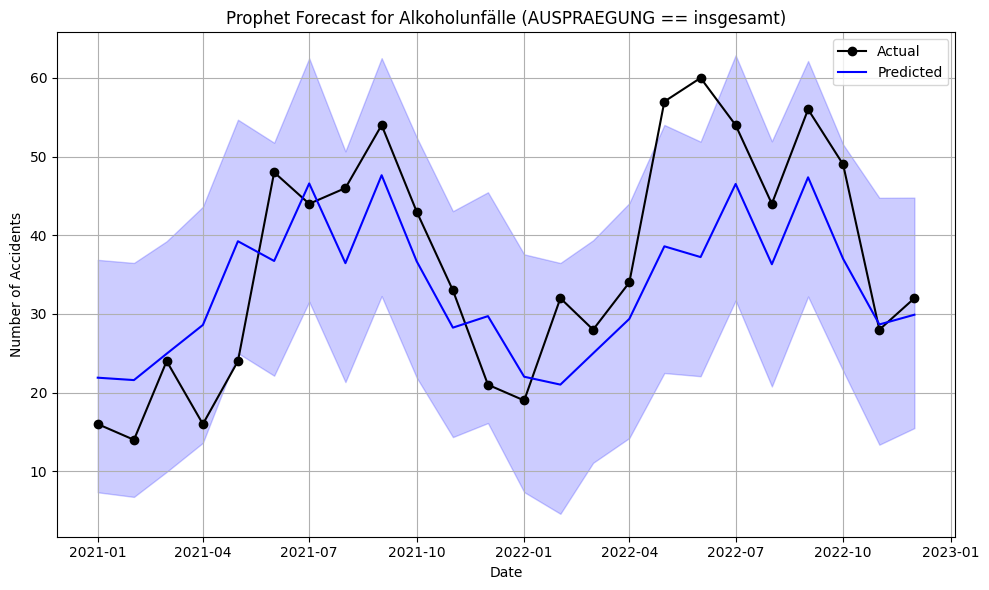


=== Forecasting for Category: Fluchtunfälle ===


22:49:50 - cmdstanpy - INFO - Chain [1] start processing
22:49:53 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 134.12


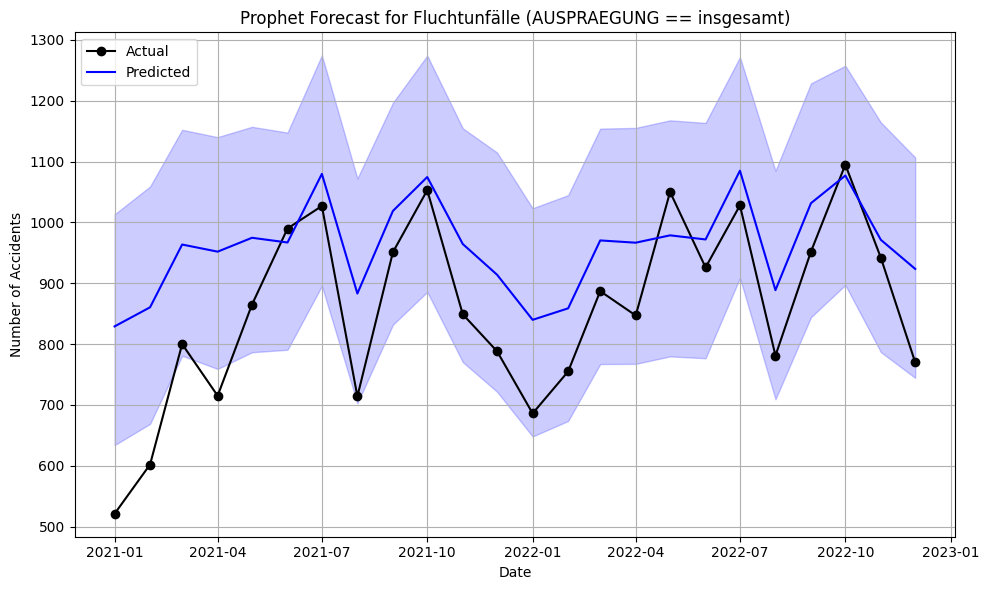


=== Forecasting for Category: Verkehrsunfälle ===


22:49:54 - cmdstanpy - INFO - Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 339.59


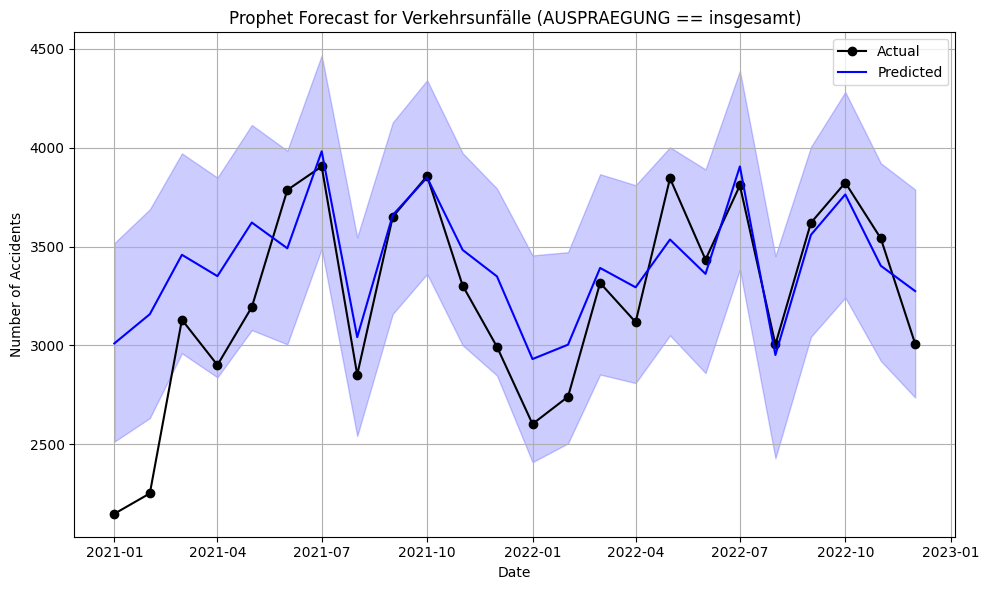

In [22]:
# Make copies of the train and test dataframes to avoid modifying original data
train_data = train_df.copy()
test_data = test_df.copy()

# Convert the 'MONAT' column to datetime format (year-month) and store in a new column 'ds'
train_data['ds'] = pd.to_datetime(train_data['MONAT'].astype(str), format='%Y%m')
test_data['ds'] = pd.to_datetime(test_data['MONAT'].astype(str), format='%Y%m')

# Rename the column 'WERT' to 'y' for compatibility with Prophet
train_data.rename(columns={'WERT': 'y'}, inplace=True)
test_data.rename(columns={'WERT': 'y'}, inplace=True)

# Extract the unique categories from 'MONATSZAHL' column to loop over
unique_categories = train_data['MONATSZAHL'].unique()

for category in unique_categories:
    print(f"\n=== Forecasting for Category: {category} ===")
    
    # Filter training data for the current category and where 'AUSPRAEGUNG' is 'insgesamt'
    train_filtered = train_data[
        (train_data['MONATSZAHL'] == category) & 
        (train_data['AUSPRAEGUNG'] == 'insgesamt')
    ].sort_values('ds').dropna(subset=['y'])
    
    # Similarly, filter the test data
    test_filtered = test_data[
        (test_data['MONATSZAHL'] == category) & 
        (test_data['AUSPRAEGUNG'] == 'insgesamt')
    ].sort_values('ds')
    
    # Initialize and fit the Prophet model on the filtered training data
    model = Prophet(interval_width=0.95)
    model.fit(train_filtered[['ds', 'y']])
    
    # Prepare the test dates as 'future' dataframe for prediction
    future_dates = test_filtered[['ds']]
    forecast = model.predict(future_dates)
    
    # Combine actual test data with predictions for comparison
    combined_results = test_filtered[['ds', 'y']].copy()
    combined_results = combined_results.merge(
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
        on='ds'
    )
    
    # Remove rows with missing actual or predicted values
    combined_results.dropna(subset=['y', 'yhat'], inplace=True)
    
    # Calculate Root Mean Squared Error (RMSE) between actual and predicted values
    rmse = np.sqrt(mean_squared_error(combined_results['y'], combined_results['yhat']))
    print(f"RMSE: {rmse:.2f}")

    # === Specific prediction for given inputs ===
    selected_category = 'Alkoholunfälle'   
    selected_type = 'insgesamt'             
    selected_year = '2021'                  
    selected_month = '01'                  

    # Build a datetime object for the target prediction date
    target_date_str = f"{selected_year}-{selected_month}"
    target_date = pd.to_datetime(target_date_str, format='%Y-%m')
    
    # If the current category matches the selected one, print detailed prediction info
    if category == selected_category:
        target_row = combined_results[combined_results['ds'] == target_date]
        
        if not target_row.empty:
            actual_value = target_row['y'].values[0]
            predicted_value = target_row['yhat'].values[0]
            confidence_lower = target_row['yhat_lower'].values[0]
            confidence_upper = target_row['yhat_upper'].values[0]

            print(f"\nPrediction for Category='{selected_category}', Type='{selected_type}', Date='{target_date.date()}':")
            print(f"Actual value: {actual_value}")
            print(f"Predicted value: {predicted_value:.2f}")
            print(f"95% confidence interval: [{confidence_lower:.2f}, {confidence_upper:.2f}]")

        # Save the trained model for this category
        safe_name = category.replace(" ", "_").replace("/", "_")
        filename = f"model_{safe_name}.pkl"
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model for category '{category}' saved as '{filename}'")
    
    # Plot the actual vs predicted values along with confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(combined_results['ds'], combined_results['y'], 'o-', label='Actual', color='black')
    plt.plot(combined_results['ds'], combined_results['yhat'], 'b-', label='Predicted')
    plt.fill_between(combined_results['ds'], combined_results['yhat_lower'], combined_results['yhat_upper'], color='blue', alpha=0.2)
    plt.title(f'Prophet Forecast for {category} (AUSPRAEGUNG == insgesamt)')
    plt.xlabel('Date')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Sarima Model


 Forecasting for Category: Alkoholunfälle
 RMSE: 8.96

 Prediction for Alkoholunfälle on 2021-01-01:
Actual: 16.0
Predicted: 21.40
95% Confidence Interval: [5.62, 37.18]
Model saved as 'sarima_model_Alkoholunfälle.pkl'


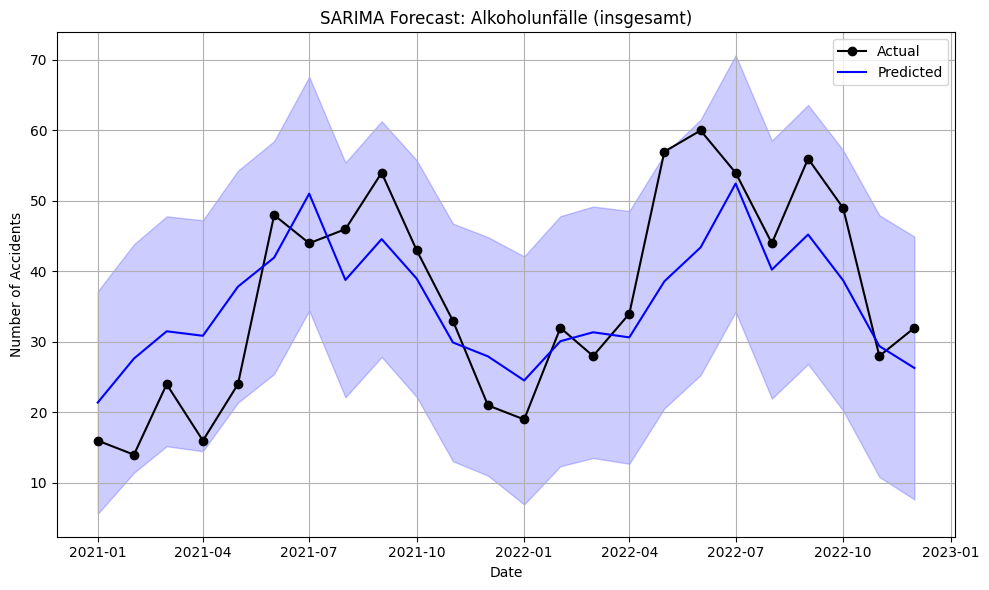


 Forecasting for Category: Fluchtunfälle
 RMSE: 93.47


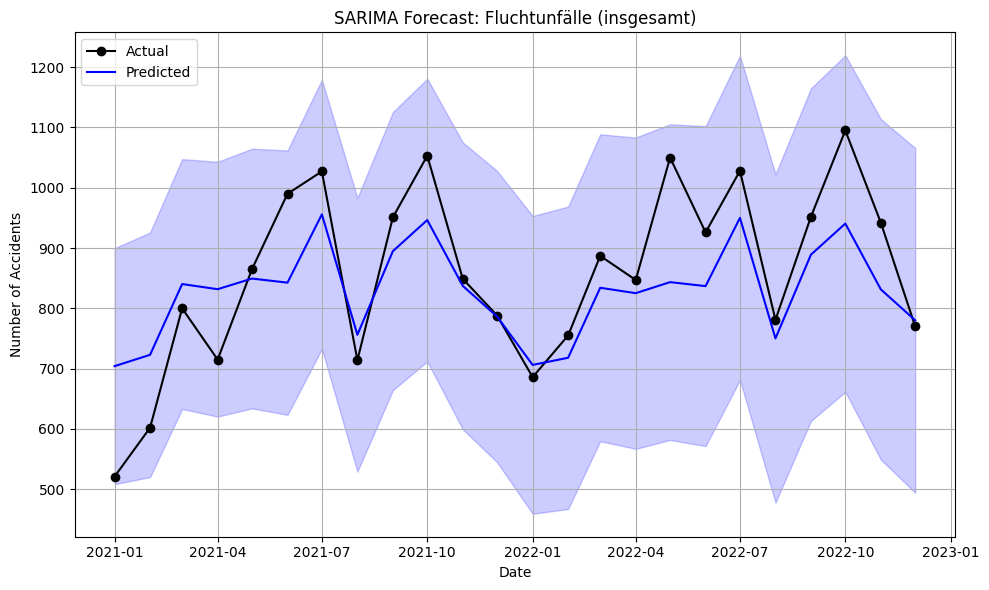


 Forecasting for Category: Verkehrsunfälle
 RMSE: 366.96


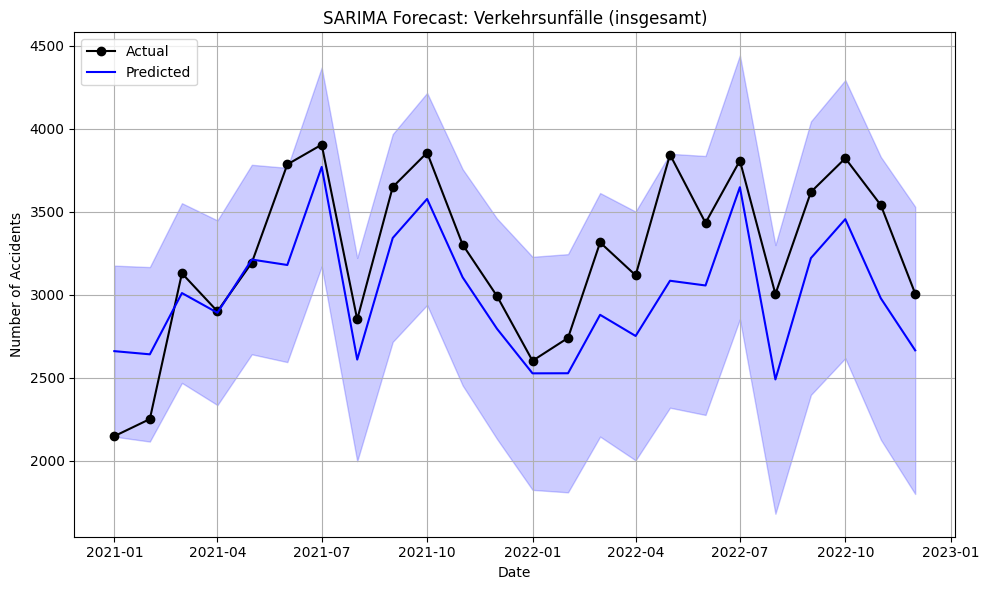

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Make copies and clean up date format 
train_data = train_df.copy()
test_data = test_df.copy()

# Turn 'MONAT' into a proper date and rename 'WERT' to 'y'
train_data['ds'] = pd.to_datetime(train_data['MONAT'].astype(str), format='%Y%m')
test_data['ds'] = pd.to_datetime(test_data['MONAT'].astype(str), format='%Y%m')
train_data.rename(columns={'WERT': 'y'}, inplace=True)
test_data.rename(columns={'WERT': 'y'}, inplace=True)

# Loop through each accident category
for category in train_data['MONATSZAHL'].unique():
    print(f"\n Forecasting for Category: {category}")

    train_filtered = train_data[
        (train_data['MONATSZAHL'] == category) & 
        (train_data['AUSPRAEGUNG'] == 'insgesamt')
    ].sort_values('ds')

    test_filtered = test_data[
        (test_data['MONATSZAHL'] == category) & 
        (test_data['AUSPRAEGUNG'] == 'insgesamt')
    ].sort_values('ds')

    # Set date as index and extract the values to forecast
    train_series = train_filtered.set_index('ds')['y']
    test_series = test_filtered.set_index('ds')['y']

    # Train SARIMA model 
    model = SARIMAX(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                    enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = model.fit(disp=False)

    #  Predict on the test period 
    forecast = sarima_result.get_forecast(steps=len(test_series))
    predicted_values = forecast.predicted_mean
    confidence_interval = forecast.conf_int()

    # Actual and predicted values together for comparison
    combined = test_filtered[['ds', 'y']].copy()
    combined['yhat'] = predicted_values.values
    combined['yhat_lower'] = confidence_interval.iloc[:, 0].values
    combined['yhat_upper'] = confidence_interval.iloc[:, 1].values

    # Remove rows where data is missing
    combined.dropna(subset=['y', 'yhat'], inplace=True)

    # Calculate and print RMSE 
    rmse = np.sqrt(mean_squared_error(combined['y'], combined['yhat']))
    print(f" RMSE: {rmse:.2f}")

    # Show prediction for a specific date 
    selected_category = 'Alkoholunfälle'
    selected_year = '2021'
    selected_month = '01'
    target_date = pd.to_datetime(f"{selected_year}-{selected_month}")

    if category == selected_category:
        row = combined[combined['ds'] == target_date]
        if not row.empty:
            print(f"\n Prediction for {selected_category} on {target_date.date()}:")
            print(f"Actual: {row['y'].values[0]}")
            print(f"Predicted: {row['yhat'].values[0]:.2f}")
            print(f"95% Confidence Interval: [{row['yhat_lower'].values[0]:.2f}, {row['yhat_upper'].values[0]:.2f}]")

        # Save this model
        model_filename = f"sarima_model_{category.replace(' ', '_').replace('/', '_')}.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(sarima_result, f)
        print(f"Model saved as '{model_filename}'")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(combined['ds'], combined['y'], label='Actual', marker='o', color='black')
    plt.plot(combined['ds'], combined['yhat'], label='Predicted', color='blue')
    plt.fill_between(combined['ds'], combined['yhat_lower'], combined['yhat_upper'], color='blue', alpha=0.2)
    plt.title(f"SARIMA Forecast: {category} (insgesamt)")
    plt.xlabel('Date')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
